In [306]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import lru_cache
from pprint import pprint

### Testando o carregamento do CSV do aprendizado da Q-table

In [307]:
qgye_csv = "qtb/qgye2/qgye2_a_15000_1000.csv"
qgye = pd.read_csv(qgye_csv, sep=";")
qgye.head()

,episode,epsilon,steps,dones,truncs,total_seconds,q_table_zeros
0,0,0.0,0,0,0,0.000000,3000
1,1,0.1,493,1,0,0.056299,2737
2,2,0.1,1000,1,1,0.170006,2276
3,3,0.1,529,2,1,0.226841,2137
4,4,0.1,231,3,1,0.251402,2137


Cálculo de número de steps até determinado episódio

In [308]:
qgye[qgye['episode']<=200]['steps'].sum()

63934

Cálculo de segundos corridos até determinado episódio

In [309]:
num = qgye.iloc[200]['total_seconds']
num

6.82568

Função que carrega CSV do aprendizado em dataframe

In [310]:
@lru_cache(maxsize=100)
def get_qgye(
    epsilon_option,
    num_episodes,
    max_steps,
):
    qgye_csv = f"qtb/qgye2/qgye2_{epsilon_option}_{num_episodes}_{max_steps}.csv"
    qgye = pd.read_csv(qgye_csv, sep=";")
    return qgye

Função que pega total de steps e segundos de um episódio de um CSV de aprendizagem

In [311]:
@lru_cache(maxsize=100)
def steps_secs(
    epsilon_option,
    num_episodes,
    max_steps,
    episode,
):
    qgye = get_qgye(
        epsilon_option,
        num_episodes,
        max_steps,
    )
    steps = qgye[qgye['episode']<=episode]['steps'].sum()
    total_seconds = qgye.iloc[episode]['total_seconds']
    return steps, total_seconds

Teste

In [312]:
steps_secs('a', 15000, 1000, 300)

(77224, 8.259225)

### Carregando o arquivo de avaliação da aprendizagem

In [313]:
eval_file_name = "qtb/qgye2/qeval.txt"

In [314]:
columns = ['epsilon_type','train_episodes','percent_dones','avg_steps']
qeval = pd.read_csv(eval_file_name, sep=";", header=None, names=columns).sort_values(['epsilon_type', 'train_episodes'])
qeval[
    (qeval['epsilon_type']=='b') & (qeval['train_episodes']>=1800) & (qeval['train_episodes']<=3000)
]

,epsilon_type,train_episodes,percent_dones,avg_steps
531,b,1800,99.00,13.030303
847,b,1900,100.00,13.070000
820,b,2000,99.33,13.036913
108,b,2100,99.00,13.026936
955,b,2200,99.67,13.053512
534,b,2300,99.67,13.053512
742,b,2400,100.00,13.070000
850,b,2500,100.00,13.070000
761,b,2600,100.00,13.070000
962,b,2700,100.00,13.070000


Adicionando ao dataframe de avaliação os steps e os segundos

In [315]:
qeval['steps'] = qeval.apply(
    lambda x: steps_secs(
        x['epsilon_type'], 15000, 1000, x['train_episodes']
    )[0],
    axis=1,
)
qeval['total_seconds'] = qeval.apply(
    lambda x: steps_secs(
        x['epsilon_type'], 15000, 1000, x['train_episodes']
    )[1],
    axis=1,
)
qeval.head()

,epsilon_type,train_episodes,percent_dones,avg_steps,steps,total_seconds
347,a,100,0.00,0.000000,44523,4.744126
1046,a,200,0.33,7.000000,63934,6.825680
567,a,300,0.33,6.000000,77224,8.259225
302,a,400,4.00,8.416667,86240,9.231001
320,a,500,10.67,9.187500,94775,10.152999


Coluna train_episodes passa a ser em centenas

In [316]:
qeval['train_episodes'] = qeval['train_episodes'] / 100
qeval.head()

,epsilon_type,train_episodes,percent_dones,avg_steps,steps,total_seconds
347,a,1.0,0.00,0.000000,44523,4.744126
1046,a,2.0,0.33,7.000000,63934,6.825680
567,a,3.0,0.33,6.000000,77224,8.259225
302,a,4.0,4.00,8.416667,86240,9.231001
320,a,5.0,10.67,9.187500,94775,10.152999


In [317]:
qeval['next_percent_dones'] = qeval['percent_dones'].shift(-1)
filtro = qeval['train_episodes'] == 150
qeval.loc[filtro, 'next_percent_dones'] = qeval.loc[filtro, 'percent_dones']
qeval

,epsilon_type,train_episodes,percent_dones,avg_steps,steps,total_seconds,next_percent_dones
347,a,1.0,0.00,0.000000,44523,4.744126,0.33
1046,a,2.0,0.33,7.000000,63934,6.825680,0.33
567,a,3.0,0.33,6.000000,77224,8.259225,4.00
302,a,4.0,4.00,8.416667,86240,9.231001,10.67
320,a,5.0,10.67,9.187500,94775,10.152999,13.33
...,...,...,...,...,...,...,...
97,g,146.0,100.00,13.070000,11353615,1732.256703,100.00
963,g,147.0,100.00,13.070000,11429132,1744.885499,100.00
751,g,148.0,100.00,13.070000,11504917,1757.582190,100.00
354,g,149.0,100.00,13.070000,11582352,1770.604701,100.00


Separa dataframe por tipos de épsilons

In [318]:
evals={}
for e_type in 'abcdefg':
    eval_t = qeval[qeval['epsilon_type']==e_type].sort_values('train_episodes')[['train_episodes', 'percent_dones', 'avg_steps', 'steps', 'total_seconds']]
    evals[e_type] = eval_t.set_index('train_episodes')
evals["a"].head()

,percent_dones,avg_steps,steps,total_seconds
train_episodes,,,,
1.0,0.00,0.000000,44523,4.744126
2.0,0.33,7.000000,63934,6.825680
3.0,0.33,6.000000,77224,8.259225
4.0,4.00,8.416667,86240,9.231001
5.0,10.67,9.187500,94775,10.152999


Testa visualização da aprendizagem de um tipo de épsilon

Text(0.5, 0, 'train episodes')

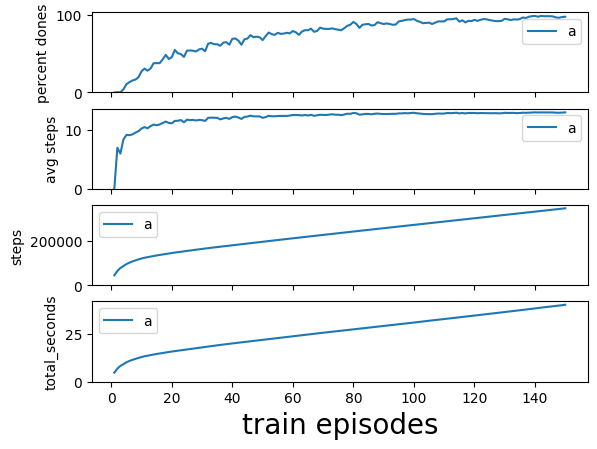

In [319]:
fig, ax = plt.subplots(4, 1, sharex=True)

# ax[0].set_title("percent dones", size = 20)
e='a'

ax[0].plot(evals[e]['percent_dones'])
ax[0].legend([e])
ax[0].set_ylabel("percent dones")
ax[0].set_ylim(bottom=0)

ax[1].plot(evals[e]['avg_steps'])
ax[1].legend([e])
ax[1].set_ylabel("avg steps")
ax[1].set_ylim(bottom=0)

ax[2].plot(evals[e]['steps'])
ax[2].legend([e])
ax[2].set_ylabel("steps")
ax[2].set_ylim(bottom=0)

ax[3].plot(evals[e]['total_seconds'])
ax[3].legend([e])
ax[3].set_ylabel("total_seconds")
ax[3].set_ylim(bottom=0)

ax[3].set_xlabel("train episodes", size = 20)

Visualização de comparação de todos os tipos de épsilons

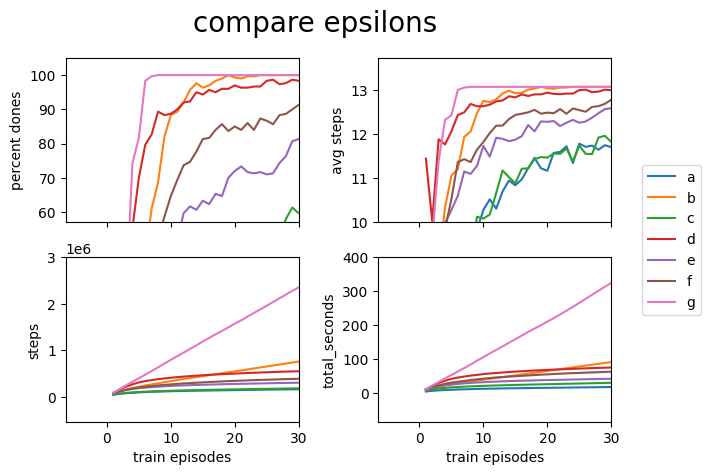

In [320]:
fig, ax = plt.subplots(2, 2, sharex=True)

for e in evals:
    ax[0, 0].plot(evals[e]['percent_dones'])
    ax[0, 1].plot(evals[e]['avg_steps'])
    ax[1, 0].plot(evals[e]['steps'])
    ax[1, 1].plot(evals[e]['total_seconds'])

fig.suptitle("compare epsilons", size = 20)

ax[0, 0].set_ylabel("percent dones")
ax[0, 0].set_xlim(right=30)
ax[0, 0].set_ylim(bottom=57)

ax[0, 1].set_ylabel("avg steps")
ax[0, 1].set_ylim(bottom=10)

ax[1, 0].set_ylabel("steps")
ax[1, 0].set_ylim(top=3_000_000)

ax[1, 1].set_ylabel("total_seconds")
ax[1, 1].set_ylim(top=400)

ax[1, 0].set_xlabel("train episodes")

ax[1, 1].set_xlabel("train episodes")

fig.legend(evals.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

Montando dict de dataframes de apenas com qtables com percent_dones 100%

[não utilizado adiante]

In [321]:
dones={}
for e_type in 'abcdefg':
    eval_t = qeval[(qeval['epsilon_type']==e_type) & (qeval['percent_dones']==100)].sort_values('train_episodes')[['train_episodes', 'avg_steps']]
    dones[e_type] = eval_t.set_index('train_episodes')
dones["b"].head()

,avg_steps
train_episodes,
19.0,13.07
24.0,13.07
25.0,13.07
26.0,13.07
27.0,13.07


Montando q100, fitrando arquivo de avaliação da aprendizagem por percent_dones 100% (em que a avaliação seguinte de percent_dones também seja 100%, para evitar "100% por sorte")

In [322]:
q100 = qeval[(qeval['percent_dones']==100) & (qeval['next_percent_dones']==100)]
q100.head()

,epsilon_type,train_episodes,percent_dones,avg_steps,steps,total_seconds,next_percent_dones
742,b,24.0,100.0,13.07,632652,75.871900,100.0
850,b,25.0,100.0,13.07,654785,78.616581,100.0
761,b,26.0,100.0,13.07,675865,81.218317,100.0
962,b,27.0,100.0,13.07,697033,83.920049,100.0
293,b,28.0,100.0,13.07,716737,86.324901,100.0


Do q100, pegando apenas o primeiro train_episodes com percent_dones 100%, para comparar steps (em dezenas de milhares) e segundos

In [323]:
q_min_episodes = q100.groupby(by=['epsilon_type']).aggregate({
    'train_episodes': ['min'],
    'steps': ['min'],
    'total_seconds': ['min'],
})
q_min_episodes.columns = q_min_episodes.columns.droplevel(1)
q_min_episodes['steps'] = q_min_episodes['steps'] / 10_000
q_min_episodes

,train_episodes,steps,total_seconds
epsilon_type,,,
b,24.0,63.2652,75.871900
d,86.0,69.5534,99.486675
g,8.0,63.2185,84.241177


Colocando os dados acima em um gráfico se percebe melhor que:
- apesar de nuito diferente a quantidade de episódios para chegar no q-table 100%, em termos de steps a diferença é pequena;
- porém, analisando os segundos, épsilom 0.9 chegou no q-table 100% em menos tempo que o épsilom 0.99.

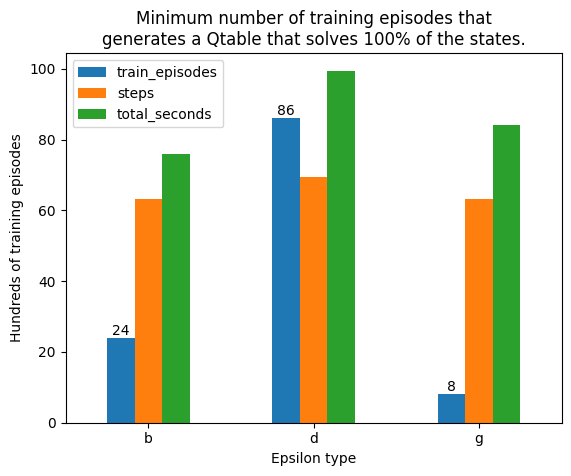

In [324]:
fig = q_min_episodes.plot(kind='bar')
plt.title('Minimum number of training episodes that\ngenerates a Qtable that solves 100% of the states.')
plt.xlabel('Epsilon type')
plt.ylabel('Hundreds of training episodes')
plt.xticks(rotation=0)
fig.bar_label(fig.containers[0], label_type='edge')
plt.show()

Comparando apenas segundos (pegando o menor como 100%, para facilitar a comparação)

In [325]:
graph_secs = q_min_episodes[['total_seconds']]
min_total_seconds = graph_secs['total_seconds'].min()
graph_secs.loc[:, 'total_seconds'] = graph_secs.loc[:, 'total_seconds'] / min_total_seconds * 100
graph_secs

,total_seconds
epsilon_type,
b,100.000000
d,131.124534
g,111.030799


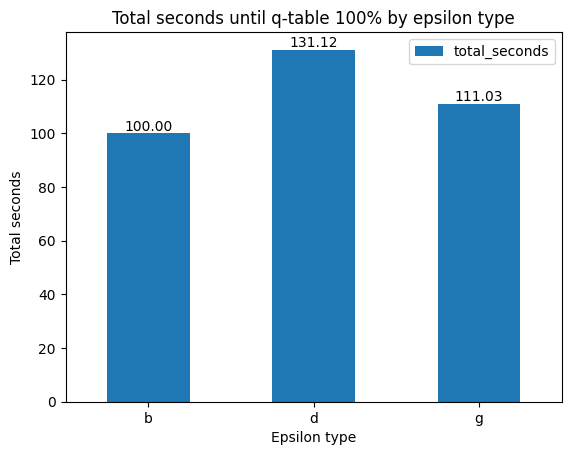

In [326]:
fig, ax = plt.subplots()

graph_secs.plot(kind='bar', ax=ax)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 5), 
                textcoords = 'offset points')

ax.set_title('Total seconds until q-table 100% by epsilon type')
ax.set_xlabel('Epsilon type')
ax.set_ylabel('Total seconds')

ax.tick_params(axis='x', rotation=0)

plt.show()